## 1. Tiền xử lý dữ liệu

In [23]:
import numpy as np
import pandas as pd
from pyvi import ViTokenizer

text = content = open("data/truyen_kieu_data.txt", "r", encoding="utf-8").read()

### Loại bỏ dấu câu

In [24]:
def loai_bo_dau_cau(text):
    dau_cau = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for p in dau_cau:
        text = text.replace(p, '')
    return text

### Tạo bộ từ vựng

In [25]:
def tao_vocab(text):
    unique_words = list(set(text))
    vocab = pd.DataFrame({
        'word': unique_words,
        'index': range(len(unique_words))
    })
    return vocab

### Tiền xử lý dữ liệu

In [26]:
def tien_xu_ly(text):
    text = text.lower()
    text = loai_bo_dau_cau(text)
    text = ViTokenizer.tokenize(text)
    text = text.split()
    stopwords = [
    "là", "và", "của", "có", "cho", "với", "một", "được", "này", "như",
    "cũng", "nhưng", "rằng", "trong", "khi", "đã", "đang", "tôi", "chúng", "bạn",
    "vì", "thì", "sẽ", "thế", "nên", "điều", "đây", "đó", "nào", "thôi"
    ]
    text = [word for word in text if word.lower() not in stopwords]
    text
    vocabulary = tao_vocab(text)
    return text, vocabulary

## 2. Thiết kế mô hình skip-gram

In [27]:
# def one_hot(words, word_to_index):
#     one_hot_matrix = np.zeros((len(words), len(word_to_index)), dtype=int)
#     for i, word in enumerate(words):
#         index = word_to_index[word]
#         one_hot_matrix[i, index] = 1
#     return one_hot_matrix

In [28]:
def one_hot(context_words, word_to_index):
    y_true = np.zeros(len(word_to_index))
    for word in context_words:
        y_true[word_to_index[word]] = 1
    return y_true

In [29]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## 3. Huấn luyện mô hình

In [30]:
EPOCHS = 30
LEARNING_RATE = 0.01
WINDOW_SIZE = 2

### center_word, contex_word

In [31]:
def tao_cap_skipgram(words, window_size=WINDOW_SIZE):
    pairs = []
    for i in range(len(words)):
        for neighbor in range(1, window_size + 1):
            if i - neighbor >= 0:
                pairs.append((words[i], words[i - neighbor]))
            if i + neighbor < len(words):
                pairs.append((words[i], words[i + neighbor]))
    return pairs

### Foward pass

In [32]:
def forward(center_word, context_words, W_in, W_out, word_to_index):
    center_idx = word_to_index[center_word]
    h = W_in[center_idx]
    u = W_out.T @ h
    y_pred = softmax(u)
    y_true = one_hot(context_words, word_to_index)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9))
    return y_pred, loss, h, y_true

### Backward pass

In [33]:
def backward(h, y_pred, y_true, W_out):
    error = y_pred - y_true
    dW_out = np.outer(h, error)
    dW_in = W_out @ error
    return dW_in, dW_out

### Train model

In [34]:
def train_skipgram_model(data, word_to_index, W_in, W_out, epochs, learning_rate):
    for epoch in range(epochs):
        total_loss = 0
        for i in range(1, len(data) - 1):
            center_word = data[i]
            context_words = [data[i - 1], data[i + 1]]

            y_pred, loss, h, y_true = forward(center_word, context_words, W_in, W_out, word_to_index)
            total_loss += loss

            dW_in, dW_out = backward(h, y_pred, y_true, W_out)

            center_idx = word_to_index[center_word]
            W_in[center_idx] -= learning_rate * dW_in
            for context_word in context_words:
                context_idx = word_to_index[context_word]
                W_out[:, context_idx] -= learning_rate * dW_out[:, context_idx]

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
    return W_in, W_out

In [35]:
text, vocab = tien_xu_ly(text)
word_to_index = {row['word']: row['index'] for _, row in vocab.iterrows()}

In [36]:
v = len(vocab)
d = 100
embedding_matrix = np.random.uniform(-0.01, 0.01, (v, d))
output_matrix = np.random.uniform(-0.01, 0.01, (d, v))
skipgram_pairs = tao_cap_skipgram(text)

In [37]:
embedding_matrix, output_matrix = train_skipgram_model(text, word_to_index, embedding_matrix, output_matrix, EPOCHS, LEARNING_RATE)

Epoch 1/50, Loss: 304847.3747
Epoch 2/50, Loss: 304843.1614
Epoch 3/50, Loss: 304836.5064
Epoch 4/50, Loss: 304820.6306
Epoch 5/50, Loss: 304769.2336
Epoch 6/50, Loss: 304576.9120
Epoch 7/50, Loss: 303822.5505
Epoch 8/50, Loss: 301288.9545
Epoch 9/50, Loss: 297486.0179
Epoch 10/50, Loss: 294282.6785
Epoch 11/50, Loss: 291795.2702
Epoch 12/50, Loss: 290256.7413
Epoch 13/50, Loss: 289161.5335
Epoch 14/50, Loss: 288386.0427
Epoch 15/50, Loss: 287977.8436
Epoch 16/50, Loss: 287917.7542
Epoch 17/50, Loss: 288057.5513
Epoch 18/50, Loss: 288244.0955
Epoch 19/50, Loss: 288293.6127
Epoch 20/50, Loss: 288123.3421
Epoch 21/50, Loss: 287807.2001
Epoch 22/50, Loss: 287456.7098
Epoch 23/50, Loss: 287132.2090
Epoch 24/50, Loss: 286890.3177
Epoch 25/50, Loss: 286689.9561
Epoch 26/50, Loss: 286423.7271
Epoch 27/50, Loss: 286094.9396
Epoch 28/50, Loss: 285757.1071
Epoch 29/50, Loss: 285482.1671
Epoch 30/50, Loss: 285317.0138
Epoch 31/50, Loss: 285310.1199
Epoch 32/50, Loss: 285514.0780
Epoch 33/50, Loss

KeyboardInterrupt: 

## 4. Đánh giá Embedding Vector

In [18]:
# Kiểm tra kết quả
print("Embedding Matrix:")
print(embedding_matrix)

Embedding Matrix:
[[-3.54781598e-03  1.19624491e-03  4.23952546e-03 ... -2.30744072e-02
  -1.11449656e-02 -3.64507760e-02]
 [ 6.21794080e-02  5.31792122e-02 -5.20624196e-02 ... -9.02419142e-03
  -3.29900052e-02 -8.37090607e-02]
 [-3.17278732e-03  2.19001724e-02 -2.98767124e-02 ... -6.82579207e-02
  -7.19268718e-02 -5.77379158e-02]
 ...
 [-3.28938530e-02  1.92816545e-01 -5.12412826e-02 ... -9.50285665e-02
   6.53196822e-03  1.18268889e-01]
 [-2.36527378e-03 -1.84470268e-04 -1.05083963e-02 ... -5.13513245e-03
  -2.88609230e-02 -2.34935124e-02]
 [ 6.34786441e-02  9.24691780e-02 -4.18046792e-02 ... -1.22171926e-01
  -1.25257343e-02  1.19814411e-01]]


In [ ]:
word_to_index

{'21hoa': 0,
 'quang': 1,
 'hầu': 2,
 'sư_tử': 3,
 'khí': 4,
 'chồng_con': 5,
 'thú': 6,
 'rất': 7,
 'thòm': 8,
 'sắt_son': 9,
 'nấn_ná': 10,
 '1865': 11,
 'mèo': 12,
 'nao': 13,
 'quáng': 14,
 'mẫu': 15,
 'xua_đuổi': 16,
 'tiệc': 17,
 'tả_tơi': 18,
 'rền_rĩ': 19,
 'dở': 20,
 'quy': 21,
 'trinh': 22,
 'vắng_tin': 23,
 'bạc_ác': 24,
 'bỏ': 25,
 'phút': 26,
 'môn_phòng': 27,
 'đài_doanh': 28,
 'bản': 29,
 '2320': 30,
 'chào_mừng': 31,
 '560vầng': 32,
 'bát': 33,
 'đơn': 34,
 'lưu_ly': 35,
 '1975': 36,
 '2755': 37,
 'giấc_tiên': 38,
 'ngọc': 39,
 'bia_miệng': 40,
 'tạ': 41,
 'hồng_nhan': 42,
 'rõ': 43,
 'thanh_nhàn': 44,
 'rộng_mở_đường': 45,
 'vô_nghĩa': 46,
 'liệu': 47,
 'tông_đường': 48,
 'tuệ': 49,
 'hương_trà': 50,
 'sâm': 51,
 'mặt_đất': 52,
 '2005': 53,
 'chẳng_đền': 54,
 'lâu': 55,
 'trang_trọng': 56,
 'gác': 57,
 '1210': 58,
 '1255': 59,
 'trụ_trì': 60,
 'hoa_râm': 61,
 '150văn': 62,
 '1430': 63,
 'chéo_khăn': 64,
 'bể_trời': 65,
 'rời': 66,
 'cù_lao': 67,
 'quen_thuộc': 68,
 '14

### Cosine Similarity
    [1] https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/

In [20]:
from numpy.linalg import norm

def cosine_similarity(vec1, vec2):
    return vec1 @ vec2 / (norm(vec1) * norm(vec2))

In [21]:
# Bộ từ kiểm tra
word_pairs = [
    ("thẹn_thùng", "e_lệ"),
    ("vui", "khóc"), 
    ("máu_ghen", "khát_khao")  
]

print("Cosine similarity:")
for word1, word2 in word_pairs:
    if word1 in word_to_index and word2 in word_to_index:
        vec1 = embedding_matrix[word_to_index[word1]]
        vec2 = embedding_matrix[word_to_index[word2]]
        similarity = cosine_similarity(vec1, vec2)
        print(f"({word1}, {word2}): {similarity:.4f}")
    else:
        print(f"({word1}, {word2}): Một trong hai từ không có trong từ điển.")


Cosine similarity:
(thẹn_thùng, e_lệ): 0.4712
(vui, khóc): 0.0587
(máu_ghen, khát_khao): -0.2837


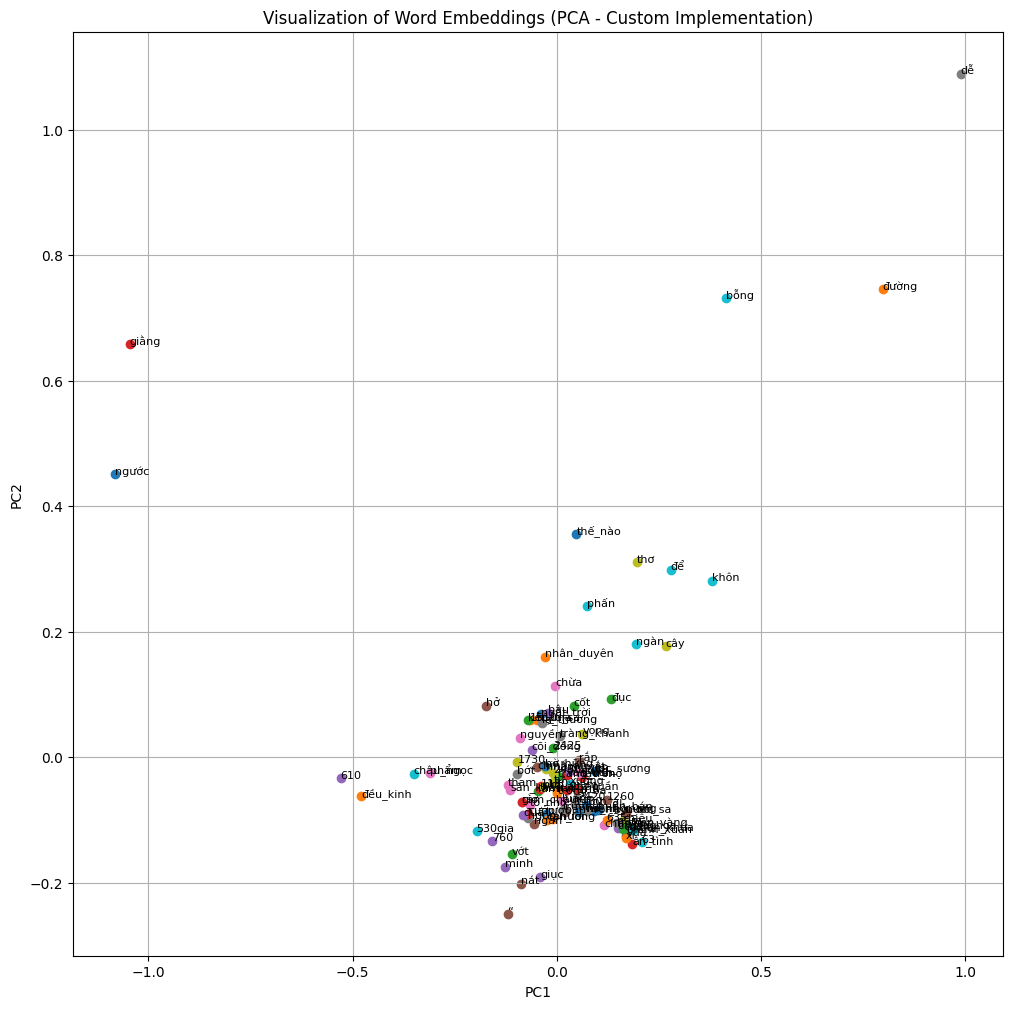

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
def pca(data, n_components=2):
    mean = np.mean(data, axis=0)
    data_centered = data - mean
    cov_matrix = np.cov(data_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    principal_components = eigenvectors[:, :n_components]
    reduced_data = np.dot(data_centered, principal_components)
    return reduced_data
reduced_embeddings = pca(embedding_matrix, n_components=2)
num_words_to_plot = 100
selected_words = random.sample(list(word_to_index.items()), num_words_to_plot)
plt.figure(figsize=(12, 12))
for word, index in selected_words:
    plt.scatter(reduced_embeddings[index, 0], reduced_embeddings[index, 1])
    plt.text(reduced_embeddings[index, 0], reduced_embeddings[index, 1], word, fontsize=8)
plt.title("Visualization of Word Embeddings (PCA - Custom Implementation)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
